In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Repeat Buyers Prediction for E-Commerce

### Problem Statement
Merchants often gain many new customers through promotions, but a significant portion of these customers are only interested in one-time deals. Therefore, the impact of promotions on long-term sales may be limited. To maximize return on investment (ROI) and reduce promotion costs, it is crucial for merchants to distinguish between one-time buyers and potential loyal customers and focus their efforts on converting the latter group.

In this project, you are provided a dataset with information on promotional shopping event from e-commerce platform. Your task is to design a system which will increase the ROI (in other words, you need to predict the probability that these new buyers would purchase items from the same merchants again within 6 months), reduce promotional cost, and identify one-time buyers. 



In [2]:
import pandas as pd

user_logs = pd.read_csv('/content/drive/MyDrive/PR_Final/user_log.csv')
user_info = pd.read_csv('/content/drive/MyDrive/PR_Final/user_info.csv')
train = pd.read_csv('/content/drive/MyDrive/PR_Final/train.csv')
test = pd.read_csv('/content/drive/MyDrive/PR_Final/test.csv')

# New Section

In [3]:
user_logs.head(5)

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,219316,472,737,801,5890.0,1018,0
1,69247,471,1266,4614,4331.0,619,2
2,69247,471,1266,4614,4331.0,619,0
3,216952,352,991,3527,869.0,626,0
4,216952,352,991,3527,869.0,626,0


In [4]:
user_logs.shape

(7402, 7)

# Data Visualization

4 Data Frames 

**User Behavior**, with 6 columns, *user_id*: a unique id for the shopper, *item_id*: a unique id for the item, *cat_id*, a unique id for the category that the item belongs to, *merchant_id*: a unique id for the merchant, *brand_id*: a unique id for the brand of the item, *time_stamp*: date the action took place (format: mmdd), and *action_type*: it is an enumerated type {0, 1, 2, 3}, where 0 is for click, 1 is for add-to-cart, 2 is for purchase and 3 is for add-to-favorite. 

**User Profile**, with 3 columns, *user_id*: a unique id for the shopper, *age_range*: user's age range, 1 for younger than 18, 2 for 18-24, 3 for 25-29, 4 for 30-34, 5 for 35-39, 6 for 40-49, 7 and 8 for older than 50, and 0 and Null for unknown, and *gender*: user's gender, 0 for female, 1 for male, and 2 for Null or unknown. 

**Training and Testing**, *user_id*: a unique id for the shopper, *merchant_id*: a unqiue id for the merchant, and *label*: it is an enumerated type{0, 1}, where 1 means repeat buyer, 0 is for non-repeat buyer. This field is blank for test data.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

### User Behavior Data Visualization


In [6]:
# Map the number action_type labels to word action_type labels
action_type_mapping = {0: "Clicks", 1: "Add to Cart", 2: "Purchases", 3: "Favorites"}

# Replace the number action_type labels with the word labels
user_logs["action_type"] = user_logs["action_type"].replace(action_type_mapping)

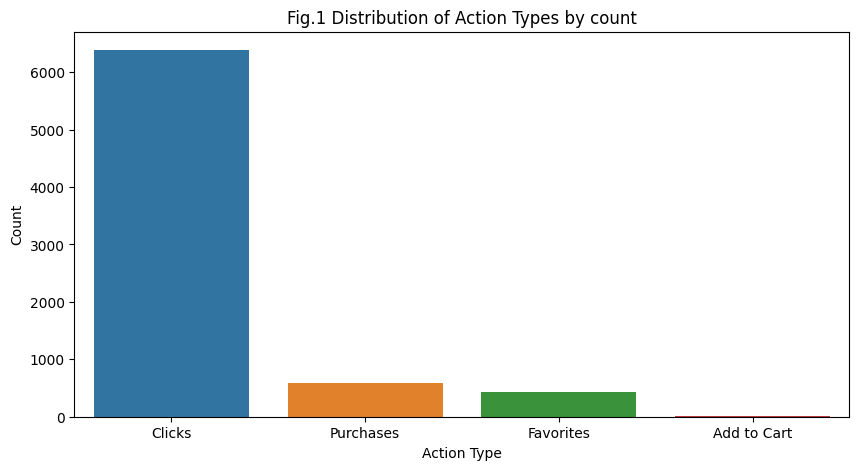

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='action_type', data=user_logs)
plt.title('Fig.1 Distribution of Action Types by count')
plt.xlabel('Action Type')
plt.ylabel('Count')

plt.show()

**Fig. 1** shows that users have clicked on items over 6000 times but have only purchased, marked favorites and added to cart less than 1000 times. Add to Cart is almost negligible because people don't want to just add to the cart without buying or the product is just not compelling enough.

In [8]:
# Merge user logs and info
merged_data = pd.merge(user_logs, user_info, on='user_id', how='left')
merged_data.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender
0,219316,472,737,801,5890.0,1018,Clicks,4.0,0.0
1,69247,471,1266,4614,4331.0,619,Purchases,4.0,1.0
2,69247,471,1266,4614,4331.0,619,Clicks,4.0,1.0
3,216952,352,991,3527,869.0,626,Clicks,5.0,2.0
4,216952,352,991,3527,869.0,626,Clicks,5.0,2.0


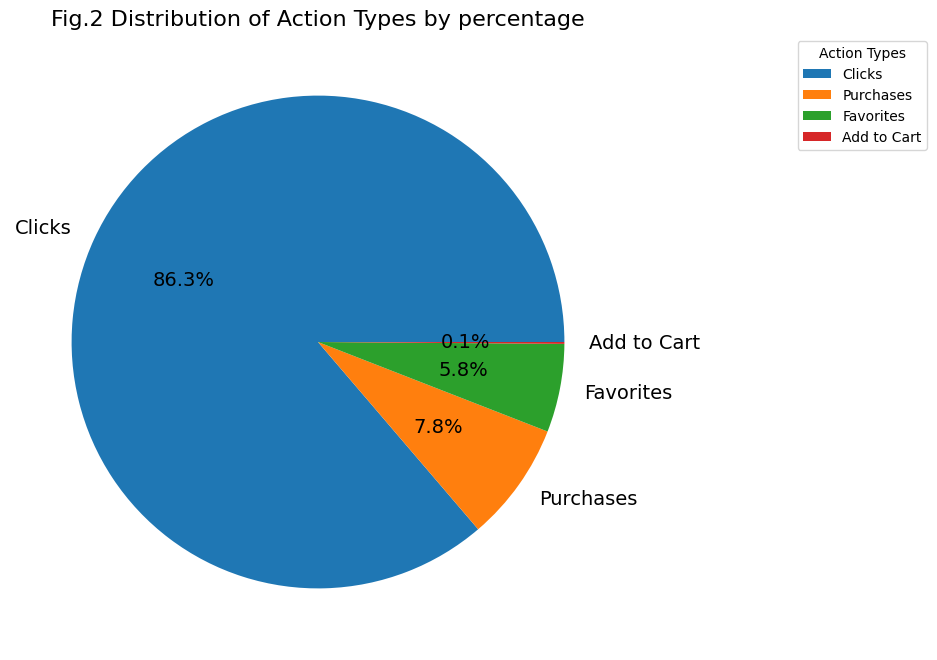

In [9]:
# Pie chart - to show action types distribution
action_type_counts = merged_data['action_type'].value_counts()
action_type_percentages = 100 * action_type_counts / len(merged_data)

plt.figure(figsize=(8,8))
plt.pie(action_type_percentages, labels=action_type_percentages.index, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.title('Fig.2 Distribution of Action Types by percentage', fontsize=16)
plt.legend(title='Action Types', loc='best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))

plt.show()

**Fig. 2** shows the distribution of action types by percentage. By analyzing the user actions, we can gain understanding of the conversion rate and the percentage of users who are one-time buyers vs. potential loyal customers. The high percentage of clicks and the low percentage of purchases suggests that users are browsing but not necessarily buying. The low percentage of add to cart may indicate that products are not interesting enough to add to cart.

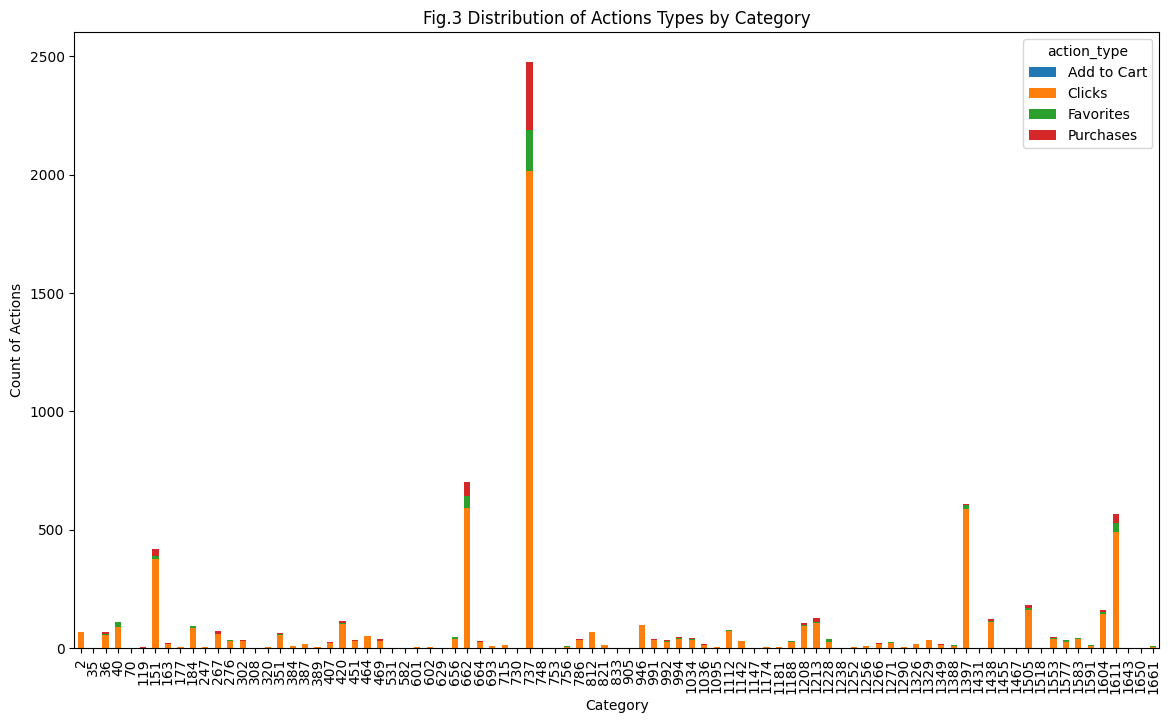

In [10]:
# Pivot table - to aggregate the number of actions by category and action type
pivot_table = user_logs.pivot_table(index="cat_id", columns="action_type", values="user_id", aggfunc="count")

# Stacked Bar Chart - to visualize the distributions of actions across different merchants or brands
pivot_table.plot(kind="bar", stacked=True, figsize=(14, 8))

plt.title("Fig.3 Distribution of Actions Types by Category")
plt.xlabel("Category")
plt.ylabel("Count of Actions")


plt.show()

**Fig. 3** shows that category 737 is the most popular and has the most actions among other categories. This could imply that category 737 is of high interest to users and may have a higher potential for sales and customer retention. It is recommended to analyze the specific products within this category that are driving the high level or user engagement.

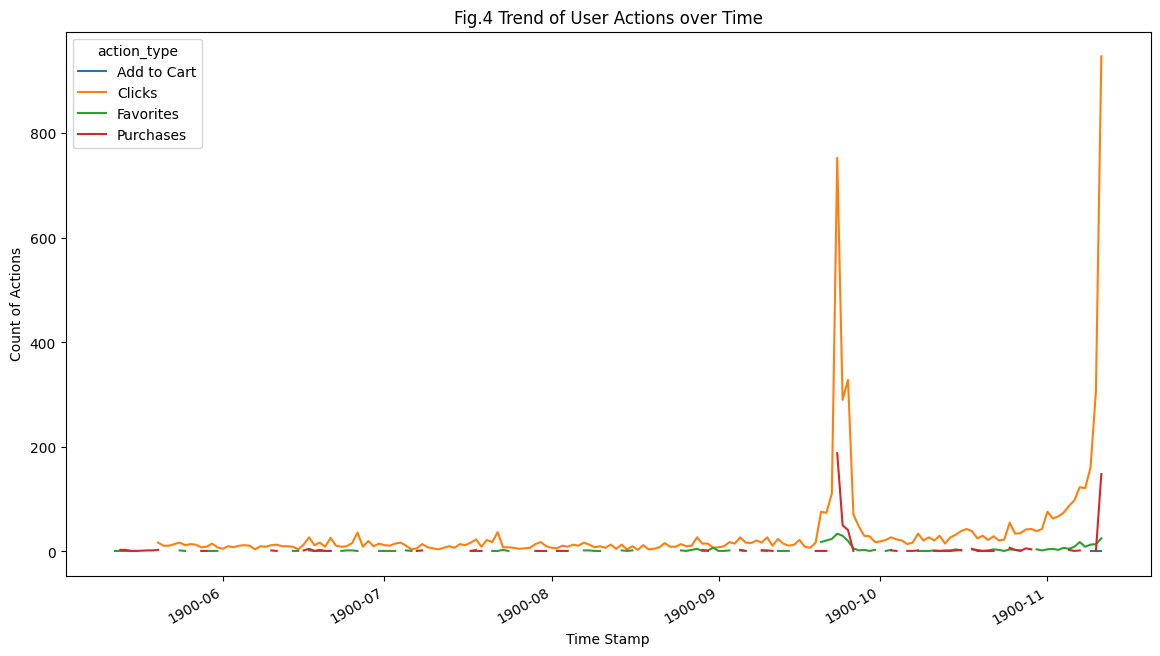

In [11]:
# Convert time_stamp to datetime format: mmdd
user_logs["time_stamp"] = pd.to_datetime(user_logs["time_stamp"], format="%m%d")

# Pivot table - to aggregate the number of actions by date and action type
pivot_table = user_logs.pivot_table(index="time_stamp", columns="action_type", values="user_id", aggfunc="count")

# Line chart - to visualize the trend of user actions over time
pivot_table.plot(kind="line", figsize=(14, 8))

plt.title("Fig.4 Trend of User Actions over Time")
plt.xlabel("Time Stamp")
plt.ylabel("Count of Actions")

plt.show()

**Fig. 4** shows that there is an increase in user actions, especially clicks and purchases on the last week of September and during the promotional Double 11 Day.The surge in user activity indicates that it is best to optimize marketing and sales strategies during these periods. Visualizing the trend of user actions overtime helps in making data-driven decisions to improve user engagement. 



## User Profile Data Visualization
*user_id*: a unique id for the shopper
*age_range*: user's age range
*   1 for younger than 18
*   2 for 18-24
*   3 for 25-29
*   4 for 30-34
*   5 for 35-39
*   6 for 40-49
*   7 and 8 for older than 50
*   0 and Null for unknown

*gender*: user's gender
*   0 for female
*   1 for male
*   2 for Null or unknown

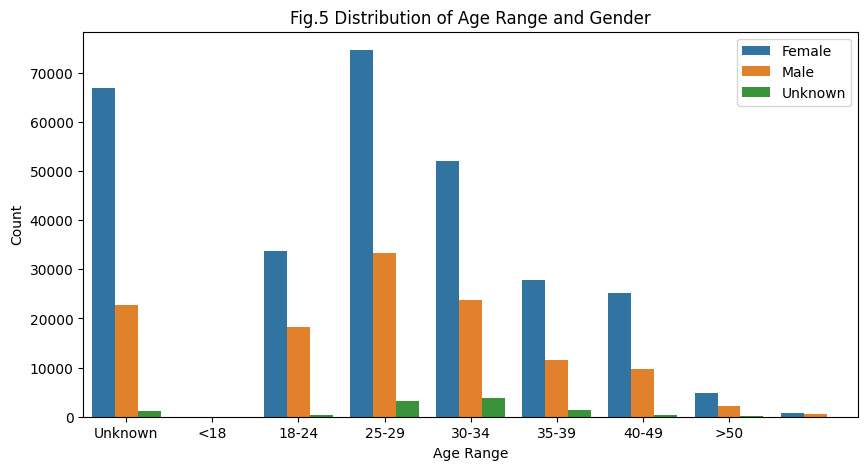

In [12]:
# Bar - to visualize distribution of age range and gender
plt.figure(figsize=(10, 5))
sns.countplot(x='age_range', hue='gender', data=user_info)
plt.title('Fig.5 Distribution of Age Range and Gender')
plt.xlabel('Age Range')
plt.ylabel('Count')

# Change the labels of the age ranges to their real values
age_labels = ['Unknown', '<18', '18-24', '25-29', '30-34', '35-39', '40-49', '>50']
plt.xticks(range(8), age_labels)

plt.legend(['Female', 'Male', 'Unknown'])

plt.show()


**Fig. 5** shows the distribution of Age Range and Gender to help better understand the customer's base. Based on this chart, Female within the age range of 25-29 are the target audience. Merchants can focus on products and promotions that are more likely to appeal to female buyers.

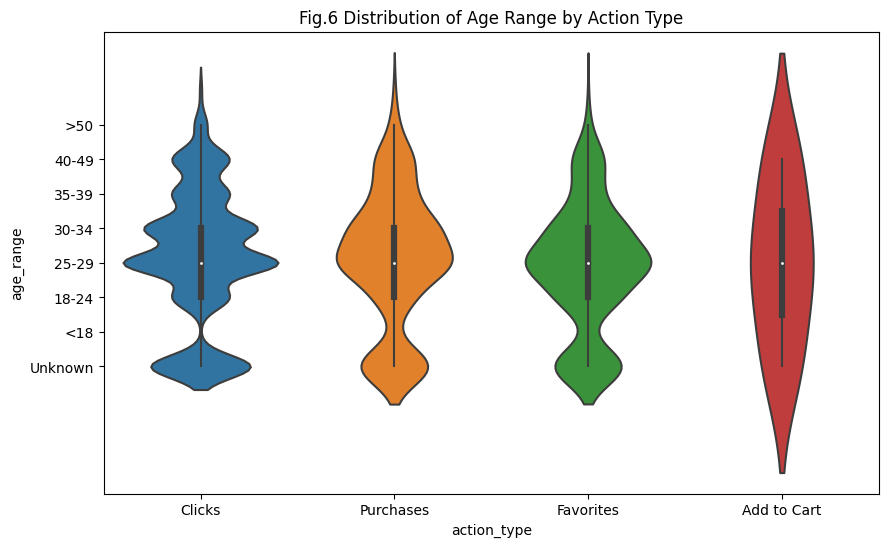

In [13]:
# Violin plot - to show age range distribution by action type
plt.figure(figsize=(10, 6))
sns.violinplot(x='action_type', y='age_range', data=merged_data)
plt.title("Fig.6 Distribution of Age Range by Action Type")

# Change the labels of the age ranges to their real values
age_labels = ['Unknown', '<18', '18-24', '25-29', '30-34', '35-39', '40-49', '>50']
plt.yticks(range(8), age_labels)

plt.show()

**Fig. 6** shows that most activities are made by users between 25 to 29 years old. Selling items appropriate to this age range would increase the chance of converting non-repeat buyers to repeat buyers.

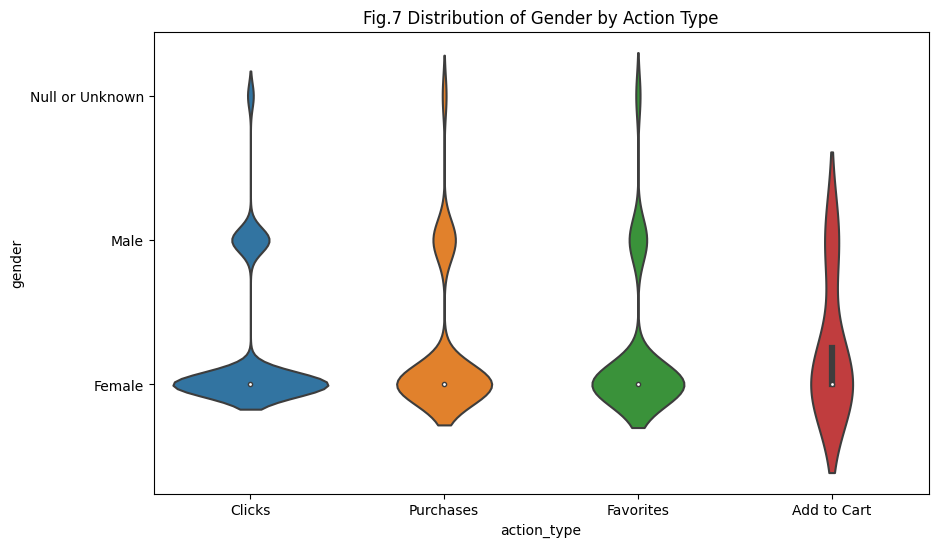

In [14]:
# Violin plot - to show gender distribution by action type
plt.figure(figsize=(10, 6))
sns.violinplot(x='action_type', y='gender', data=merged_data)
plt.title("Fig.7 Distribution of Gender by Action Type")


# Change the labels of the age ranges to their real values
gender_labels = ['Female', 'Male', 'Null or Unknown']
plt.yticks(range(3), gender_labels)

plt.show()

**Fig. 7** shows that most of the buyers are female. It is recommended to plan for product enhancement and promotions for female buyers and launching new items for men to increase their interest in buying.

In [15]:
# Create age and gender purchase data
age_purchase_data = merged_data[merged_data['action_type'] == 2].groupby(['age_range', 'time_stamp']).size().reset_index(name='num_purchases')
gender_purchase_data = merged_data[merged_data['action_type'] == 2].groupby(['gender', 'time_stamp']).size().reset_index(name='num_purchases')

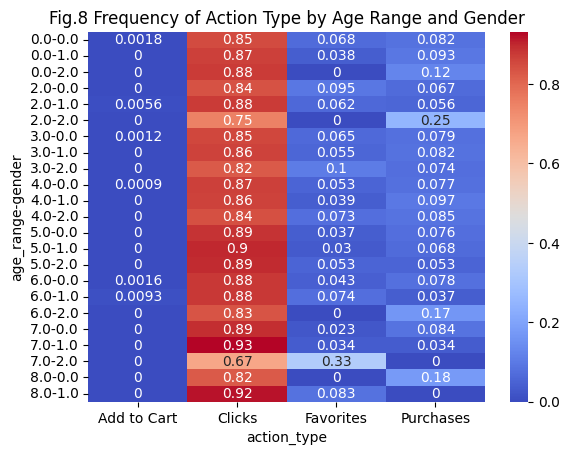

In [16]:
# Heatmap - to visualize the action type frequency by age range and gender
age_gender_action = merged_data.groupby(['age_range', 'gender', 'action_type']).size().unstack()
age_gender_action.fillna(0, inplace=True)

# Normalize the data
age_gender_action = age_gender_action.div(age_gender_action.sum(axis=1), axis=0)

sns.heatmap(age_gender_action, annot=True, cmap='coolwarm')
plt.title("Fig.8 Frequency of Action Type by Age Range and Gender")

plt.show()

**Fig. 8** shows the frequency of action type by age range and gender. This can provide insights into the shopping behavior of different age and gender groups.

For example, male buyers in the age between 40-49 have a higher frequency of adding items to their cart but a lower frequency of making purchases. This may indicate that these buyers are more price-sensitive than female buyers in the same age range.

On the other hand, female buyers between the age range 40-49 have lower frequency on adding items to cart but higher frequency on purchasing the items. This might indicate that these buyers are more impulsive buyers or have a higher disposable income than male buyers in the same age range.


## Training Data Visualization

In [17]:
# Map the number number labels to word labels
buyer_mapping = {0: "Non-repeat Buyer", 1: "Repeat Buyer"}

# Replace the number labels with the word labels
train["label"] = train["label"].replace(buyer_mapping)

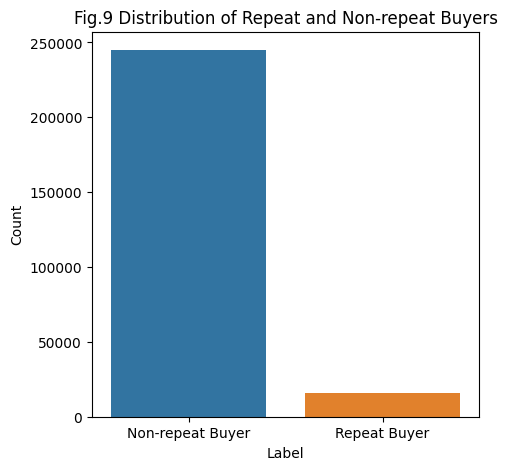

In [18]:
# Bar - to visualize distribution of repeat and non-repeat buyers
plt.figure(figsize=(5, 5))
sns.countplot(x='label', data=train)
plt.title('Fig.9 Distribution of Repeat and Non-repeat Buyers')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

**Fig. 9** shows the distribution of those who are making purchases versus those who are not. This provides a clear and concise representation of repeat vs. non-repeat buyers. This helps in understanding the proportion of customers repeat buyers versus non-repeat buyers.

This chart shows that there is an overwhelming number of Non-repeat buyers. This is the main problem we want to solve. It is recommended to focus more on improving the overall customer experience to encourage repeat purchases. 

This chart provides valuable information that can be helpful for businesses to make decisions about their marketing and customer retention strategies.

In [19]:
# Group and count the data by merchant_id and label
merchant_counts = train.groupby(["merchant_id", "label"]).size().reset_index(name="count")

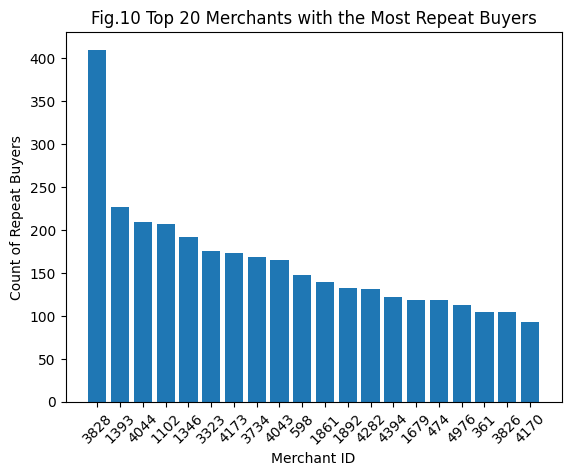

In [20]:
# Bar chart - to show the top 20 merchants with the most repeat buyers
repeat_buyers = train[train['label'] == "Repeat Buyer"]
merchant_counts = repeat_buyers['merchant_id'].value_counts().head(20)

plt.bar(range(len(merchant_counts)), merchant_counts.values)
plt.xticks(range(len(merchant_counts)), merchant_counts.index, rotation=45)

plt.title('Fig.10 Top 20 Merchants with the Most Repeat Buyers')
plt.xlabel('Merchant ID')
plt.ylabel('Count of Repeat Buyers')

plt.show()


**Fig. 10** shows the behavior of customers on the platform. Merchant ID 3828 is identified as the merchant with the most repeat buyers. Identifying the top merchants with the most repeat buyers should focus on providing better support and resources, which could lead to increased customer satisfaction and loyalty.

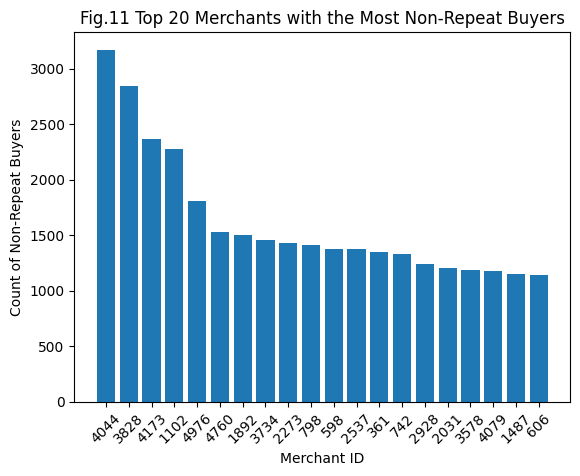

In [21]:
# Bar chart - to show the top 20 merchants with the most non-repeat buyers
non_repeat_buyers = train[train['label'] == "Non-repeat Buyer"]
merchant_counts = non_repeat_buyers['merchant_id'].value_counts().head(20)

plt.bar(range(len(merchant_counts)), merchant_counts.values)
plt.xticks(range(len(merchant_counts)), merchant_counts.index, rotation=45)

plt.title('Fig.11 Top 20 Merchants with the Most Non-Repeat Buyers')
plt.xlabel('Merchant ID')
plt.ylabel('Count of Non-Repeat Buyers')

plt.show()



**Fig. 11** shows which merchants have the most non-repeat buyers. Merchant ID 4044 is identified as the merchant with the most non-repeat buyers. The merchants on this list should identify potential areas for improvement in customer retention strategies. This can be used for comparing a merchant's performance to its competitors in terms of customer retention. 

As noticed on Fig. 10, 9 merchants (4044, 3828, 4173, 1102, 4976, 1892, 3734, 598, 361) also have the most repeat buyers. This could suggest that these merchants are popular and have a lot of customers but are struggling to keep them as there are overwhelming numbers of non-repeat buyers.

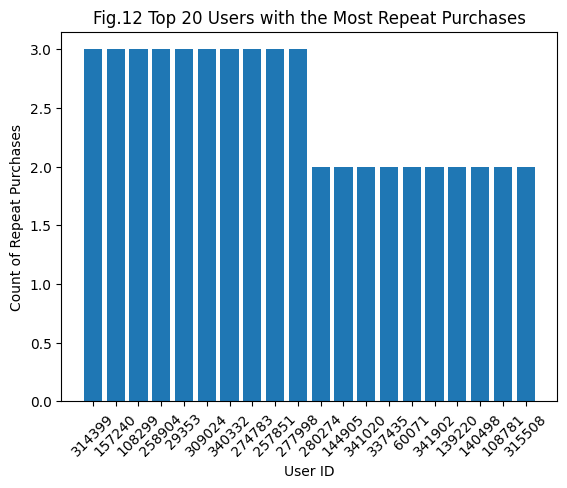

In [22]:
# Bar chart - to show the top 20 users with the most repeat buyers
repeat_buyers = train[train['label'] == "Repeat Buyer"]
user_counts = repeat_buyers['user_id'].value_counts().head(20)

plt.bar(range(len(user_counts)), user_counts.values)
plt.xticks(range(len(user_counts)), user_counts.index, rotation=45)

plt.title('Fig.12 Top 20 Users with the Most Repeat Purchases')
plt.xlabel('User ID')
plt.ylabel('Count of Repeat Purchases')

plt.show()


**Fig. 12** shows which users have the most repeat purchases. By identifying these users, businesses can analyze the behavior of these repeat purchasers and come up with a new strategy to attract new customers and improve customer retention.

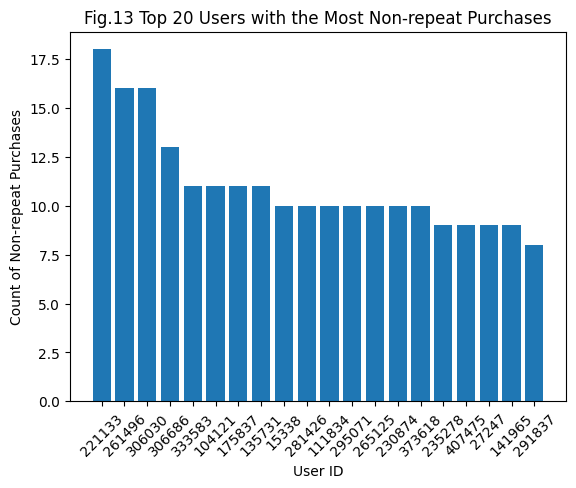

In [23]:
# Bar chart - to show the top 20 users with the most non-repeat buyers
repeat_buyers = train[train['label'] == "Non-repeat Buyer"]
user_counts = repeat_buyers['user_id'].value_counts().head(20)

plt.bar(range(len(user_counts)), user_counts.values)
plt.xticks(range(len(user_counts)), user_counts.index, rotation=45)

plt.title('Fig.13 Top 20 Users with the Most Non-repeat Purchases')
plt.xlabel('User ID')
plt.ylabel('Count of Non-repeat Purchases')

plt.show()


**Fig. 13** shows which users have the most non-repeat purchases. It is important to identify these users and analyze their behavior. Analyzing the behavior of these users can help identify potential issues with the products and services and come up with new marketing strategies to encourage repeat purchases.